PROJECT CODE

TASKS:

1_Expansão com hidrolases - MEME and BLAST
2_Features - NS Machine learning - Clustering and Kmers
3_Functional Analysis - MOFA 
4_Estructural - Ensemble 

O que posso aplicar para a generalidade dos casos?


In [14]:
# Blast
import os
import pandas as pd
from Bio.Blast.Applications import NcbiblastpCommandline

# Arquivos de entrada
initial_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/initial_sequences.fasta"
new_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta"
output_file = "/Users/Sergiomendes/Desktop/Project/data/blast_results.tsv"

# Remover o arquivo de saída, se existir
if os.path.exists(output_file):
    os.remove(output_file)

# Executar o BLAST usando o package do Anaconda e gravar os resultados no arquivo blast_results.tsv
blastp_cline = NcbiblastpCommandline(query=new_sequences_file, subject=initial_sequences_file, outfmt=6, out=output_file, evalue=0.45)
stdout, stderr = blastp_cline()

# Definir os cabeçalhos das colunas
column_headers = ['Query ID', 'Subject ID', 'Percent Identity', 'Alignment Length', 'Mismatches', 'Gap Openings',
                  'Query Start', 'Query End', 'Subject Start', 'Subject End', 'E-Value', 'Bit Score']

# Ler o arquivo de saída do BLAST
blast_results = pd.read_csv(output_file, sep='\t', header=None)

# Adicionar os cabeçalhos às colunas do DataFrame
blast_results.columns = column_headers

# Salvar o DataFrame com os cabeçalhos no arquivo de saída
blast_results.to_csv(output_file, sep='\t', index=False)


In [15]:
#MEME

# Arquivos de entrada
sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/merge_sequences.fasta"
output_file = "/Users/Sergiomendes/Desktop/Project/data/meme_output"

import subprocess

# Comando para executar o programa meme e redirecionar a saída para o arquivo
command = ["/opt/local/bin/meme",sequences_file, "-nmotifs", "3", "-oc", output_file]

# Executar o comando
subprocess.run(command)


KeyboardInterrupt: 

Counter({1: 100, 0: 45})
Counter({0: 100, 1: 100})


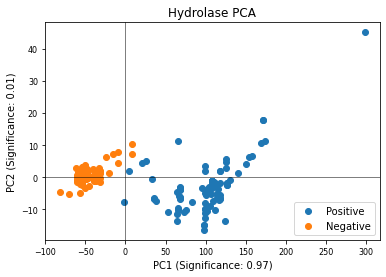

In [17]:
from Bio import SeqIO
import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter
from numpy import where

# Extrair os descriptores
def extract_descriptors(sequence):
    descriptor = [len(sequence), sequence.count('A'), sequence.count('C'),
                  sequence.count('D'), sequence.count('E'), sequence.count('F'),
                  sequence.count('G'), sequence.count('H'), sequence.count('I'),
                  sequence.count('K'), sequence.count('L'), sequence.count('M'),
                  sequence.count('N'), sequence.count('P'), sequence.count('Q'),
                  sequence.count('R'), sequence.count('S'), sequence.count('T'),
                  sequence.count('V'), sequence.count('W'), sequence.count('Y')]
    return descriptor

# Construir o dataframe
def create_dataframe(positive_file, negative_file):
    positive_sequences = list(SeqIO.parse(positive_file, 'fasta'))
    negative_sequences = list(SeqIO.parse(negative_file, 'fasta'))

    sequences = positive_sequences + negative_sequences
    labels = [0] * len(positive_sequences) + [1] * len(negative_sequences)
    descriptors = [extract_descriptors(str(seq.seq)) for seq in sequences]

    df = pd.DataFrame({'Label': labels, 'Descriptor': descriptors})
    return df


positive_file = '/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta'
negative_file = '/Users/Sergiomendes/Desktop/Project/data/notPET.fasta'

df = create_dataframe(positive_file, negative_file)

# Executar PCA
pca = PCA(n_components=2)  # Set n_components to 2
descriptors = df['Descriptor'].values.tolist()
pca_result = pca.fit_transform(descriptors)

# Adicionar os resultados ao dataframe
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

# Extrair os valores de significância
explained_variance_ratio = pca.explained_variance_ratio_

# Extrair features e labels
X = df[['PC1', 'PC2']].values
y = df['Label'].values

# Sumarizar a distribuição de classes
counter = Counter(y)
print(counter)

# Aplicar SMOTE de modo a gerar amostras sintéticas para os casos negativos
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Sumarizar a nova distribuição de classes
counter = Counter(y_resampled)
print(counter)

# Mapeamento das labels para as legendas desejadas
label_legend_mapping = {0: 'Positive', 1: 'Negative'}

# Visualizar o gráfico de dispersão 
for label, _ in counter.items():
    row_ix = where(y_resampled == label)[0]
    plt.scatter(X_resampled[row_ix, 0], X_resampled[row_ix, 1], label=label_legend_mapping[label])

#Título
plt.title('Hydrolase PCA')

# Legenda do eixo X
plt.xlabel('PC1')
plt.xticks(fontsize=8)

# Legenda do eixo Y
plt.ylabel('PC2')
plt.yticks(fontsize=8)

# Eixos X e Y
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Adicionar os valores de significância nos eixos
plt.xlabel(f'PC1 (Significance: {explained_variance_ratio[0]:.2f})')
plt.xticks(fontsize=8)
plt.ylabel(f'PC2 (Significance: {explained_variance_ratio[1]:.2f})')
plt.yticks(fontsize=8)
plt.legend()

# Salvar o gráfico
save_path = '/Users/Sergiomendes/Desktop/Project/data/clustering_result.png'
plt.savefig(save_path)

plt.show()


In [2]:
#FUNCTIONAL ANALYSIS - KEGG

import requests
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

merge_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta"
output_file = "/Users/Sergiomendes/Desktop/Project/data/KEGG_output.txt"

# Carregar as sequências de proteínas do arquivo fasta
sequences = []
with open(merge_sequences_file, 'r') as fasta_file:
    for record in SeqIO.parse(fasta_file, 'fasta'):
        sequences.append(str(record.seq))

# Anotação funcional das sequências usando KEGG
with open(output_file, 'w') as output:
    for sequence in sequences:
        protein = ProteinAnalysis(sequence)

        # Exemplo: cálculo da composição de aminoácidos
        composition = protein.get_amino_acids_percent()

        # Exemplo: pesquisa de vias metabólicas relacionadas a PET degradation
        pathway_response = requests.get(f"http://rest.kegg.jp/find/genes/{protein.sequence}")
        pathway_results = pathway_response.text

        # Exemplo: pesquisa de anotações funcionais no KEGG Orthology (KO)
        ko_response = requests.get(f"http://rest.kegg.jp/link/ko/{protein.sequence}")
        ko_results = ko_response.text

        # Escrever os resultados no arquivo de saída
        output.write(f"Composição de aminoácidos: {composition}\n")
        output.write(f"Vias metabólicas relacionadas: {pathway_results}\n")
        output.write(f"Anotações funcionais (KO): {ko_results}\n")
        output.write("---\n")


In [2]:
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import SeqIO

def blastkoala_annotation(fasta_file):
    # Ler o ficheiro fasta
    sequences = SeqIO.parse(fasta_file, "fasta")

    annotations = []

# Executa um BLAST para cada sequencia
    for sequence in sequences:
        # BLAST search contra KEGG DB
        result_handle = NCBIWWW.qblast("blastp", "ko", sequence.seq)
        print('KKKKKKKKKKK')

# Analisar o output
        blast_record = NCBIXML.read(result_handle)

# Extrair o melhor hit
        if blast_record.alignments:
            alignment = blast_record.alignments[0]
            hit_def = alignment.hit_def
            annotations.append((sequence.id, hit_def))
        else:
            annotations.append((sequence.id, "No hit found"))

    return annotations


fasta_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta"  # Replace with your FASTA file path
annotations = blastkoala_annotation(fasta_file)

# Print das anotações
for sequence_id, annotation in annotations:
    print(f"Sequence ID: {sequence_id}\tAnnotation: {annotation}")


KeyboardInterrupt: 

In [ ]:
# ESTRUCTURAL ANALYSIS EVcouplings
import subprocess

new_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/new_sequences.fasta"
def evcouplings_analysis(fasta_file):
    # Executa o  EVcouplings na linha de comandos
    command = f"evcouplings {fasta_file} --method=plmc"
    output = subprocess.check_output(command, shell=True).decode('utf-8')

    # Extração da informação resultante do output
    lines = output.strip().split('\n')
    family_info = {}
    for line in lines:
        if line.startswith('SEQUENCE'):
            sequence_id, family = line.split('\t')
            family_info[sequence_id] = family
    
    return family_info

# Executar o comando
family_info = evcouplings_analysis(new_sequences_file)

# Print do output
for sequence_id, family in family_info.items():
    print(f"Sequence ID: {sequence_id}\tFamily: {family}")


